In [1]:
import os
import sys
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
sys.path.append("../src")

from preprocessing import load_unsw_data, preprocess_data

In [2]:
df = load_unsw_data("../data/")
X_train, X_test, y_train, y_test = preprocess_data(
        df, 
        model_type='supervised',
        apply_smote=True,
        smote_strategy=0.3
    )
print(f"Loaded dataset. Test shape: {X_test.shape}")

Loaded UNSW-NB15 dataset: 2540047 rows, 49 columns
Dropped 'attack_cat' column (prevented leakage).
Dropped 7 highly correlated feature(s): ['sloss', 'dloss', 'Dpkts', 'dwin', 'Ltime', 'synack', 'ackdat']
Class distribution before SMOTE:
Label
0    1371840
1      69750
Name: count, dtype: int64
Class distribution after SMOTE:
Label
0    1371840
1     411552
Name: count, dtype: int64
SMOTE applied: Training set expanded to 1783392 samples
Data split complete → Train: (1783392, 40), Test: (617825, 40)
Label distribution (train):
Label
0    0.769231
1    0.230769
Name: proportion, dtype: float64
Loaded dataset. Test shape: (617825, 40)


In [3]:
models_dir = "../outputs/models/"
model_files = {
    "Random Forest": "random_forest.pkl",
    "Logistic Regression": "logistic_regression.pkl",
    "XGBoost": "xgboost.pkl",
    "LightGBM": "lightgbm.pkl"
}

models = {}
for name, file in model_files.items():
    path = os.path.join(models_dir, file)
    if os.path.exists(path):
        models[name] = joblib.load(path)
        print(f"Loaded {name}")
    else:
        print(f"{file} not found. Skipping...")

Loaded Random Forest
Loaded Logistic Regression
Loaded XGBoost
Loaded LightGBM


In [4]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1-score", ascending=False)
results_df.reset_index(drop=True, inplace=True)
print("\n=== Summary ===")
display(results_df)


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9979    0.9965    0.9972    587932
           1     0.9330    0.9596    0.9461     29893

    accuracy                         0.9947    617825
   macro avg     0.9655    0.9781    0.9717    617825
weighted avg     0.9948    0.9947    0.9947    617825


=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9997    0.9850    0.9923    587932
           1     0.7716    0.9951    0.8692     29893

    accuracy                         0.9855    617825
   macro avg     0.8857    0.9901    0.9308    617825
weighted avg     0.9887    0.9855    0.9864    617825


=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9974    0.9957    0.9965    587932
           1     0.9176    0.9490    0.9330     29893

    accuracy                         0.9934    617825
   macro avg     0.9575    0.9723    0.9648    617825
weigh

,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.994710,0.994800,0.994710,0.994746
1,LightGBM,0.994061,0.994100,0.994061,0.994079
2,XGBoost,0.993408,0.993540,0.993408,0.993460
3,Logistic Regression,0.985510,0.988709,0.985510,0.986373


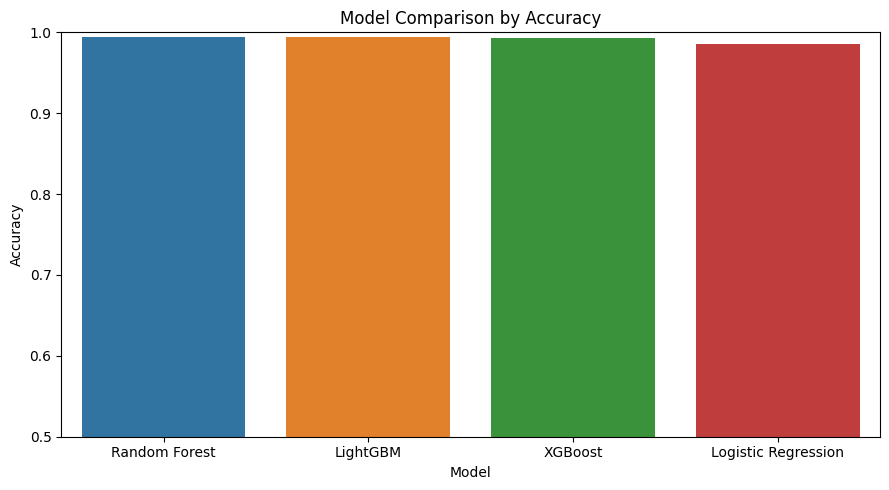

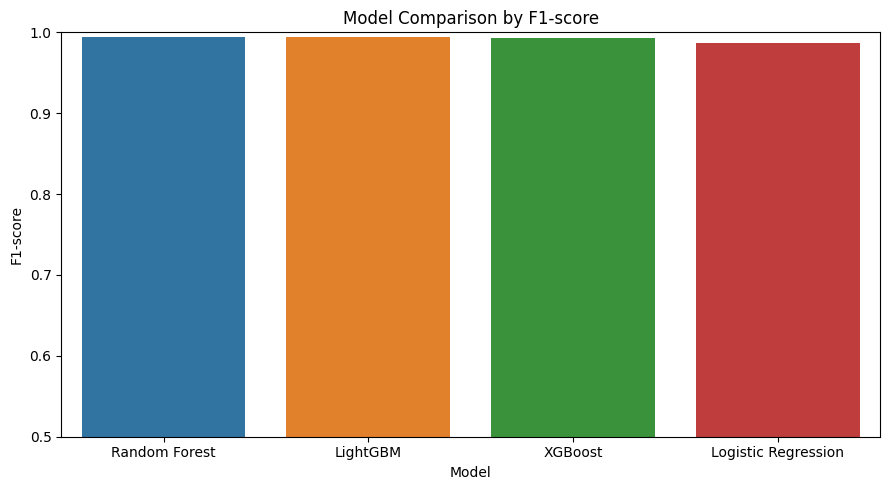

In [5]:
plt.figure(figsize=(9,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, hue="Model", dodge=False)
plt.title("Model Comparison by Accuracy")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig("../outputs/figures/model_accuracy_comparison.png", dpi=300)
plt.show()

plt.figure(figsize=(9,5))
sns.barplot(x="Model", y="F1-score", data=results_df, hue="Model", dodge=False)
plt.title("Model Comparison by F1-score")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig("../outputs/figures/model_f1_comparison.png", dpi=300)
plt.show()

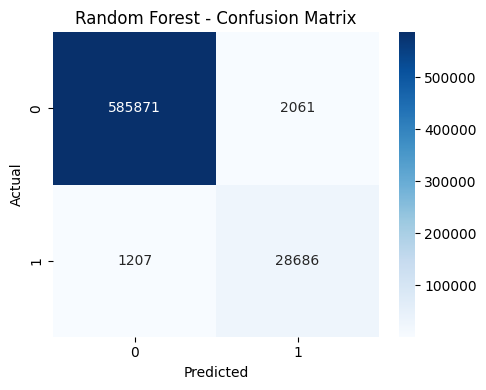

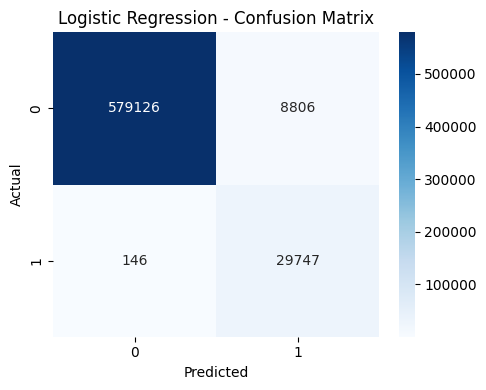

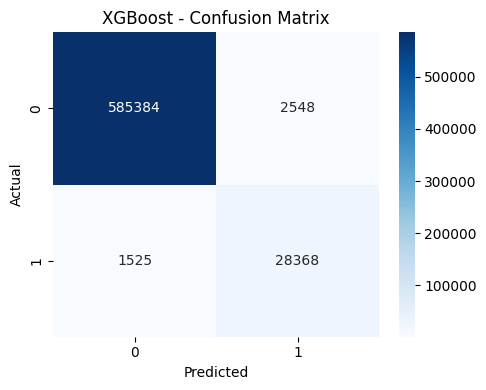

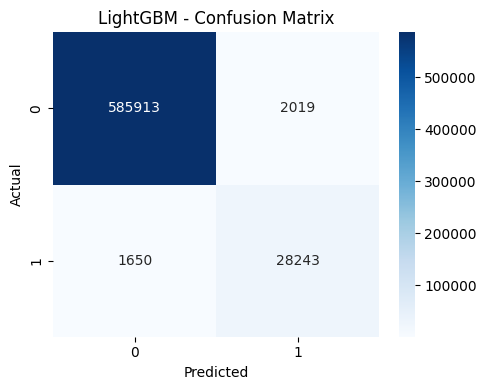

In [6]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{name.replace(' ', '_')}_confusion_matrix.png", dpi=300)
    plt.show()

In [7]:
best_model = results_df.iloc[0]
print(f"Best Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-score: {best_model['F1-score']:.4f}")

Best Model: Random Forest
Accuracy: 0.9947
F1-score: 0.9947
